# <span style="color:#BC48CD"> Numerical Simulation Laboratory (NSL) - Esercitazione 6</span>
#### <span style="color:#9C19ED">Author: </span>    Alessia Sambruna <span style="color:#9C19ED">Student number: </span>     942397



## Modello di Ising
Il modello di Ising è un modello utilizzato per descrivere il comportamento di un magnete. La premessa è che un magnete è un materiale composto da momenti di dipolo magnetico di diversi spin atomici all'interno del materiale. All'interno del modello si divide il materiale in questione in celle, a ciascuna delle quali viene assegnato un determinato valore di spin. Nella sua forma più semplice, ciascuno spin può avere valore up o down. 
In meccanica statistica il modello di Ising 1D è risolvibile analiticamente. Per un sistema di N spin l'interazione con i primi vicini è descritta da 
$$
H = 
-J\sum_{i=1}^N s_i s_{i+1}
-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}) 
$$
dove $\{ s_i \}_{i=1,N}$ sono spin di valore variabile tra $\{-1;1\}$, $J>0$ (nel modello ferromagnetico), e si assime $s_{N+1} = s_{1}$.

A partire dalla funzione di partizione 
$$
Z=\sum_{\{ s_i \}} \exp \left( -\beta H\right) 
$$
si può calcolare l'energia libera di Helmholtz $A = -k_B T \ln Z$. 
A partire da questa quantità si possono determinare tutte le altre quantità termodinamiche: 

- l'***energia interna*** per spin (con $h=0$):
$$
\frac{U(N,T)}{N} = \frac{\langle H \rangle}{N}
= ...= -J \tanh (\beta J) \Biggl( \frac{1 + \tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$
- La ***capacità termica*** : 
$$\frac{C(N,T)}{N} = \frac{1}{N}\frac{\partial U(N,T)}{\partial T} =\\
\underset{h=0}= 
k_B (\beta J)^2 \left\{ 1+\tanh^N (\beta J)+(N-1)\tanh^2 (\beta J)+(N-1)\frac{\tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)}
- N \left[ \frac{\tanh (\beta J) + \tanh^{N-1} (\beta J)}{1+\tanh^N (\beta J)} \right]^2 \right\}
$$
- La ***magnetizzazione*** : 
$$
M(N,T,h) = -\frac{\partial A}{\partial h} = ... = \left\langle \sum_{i=1,N}s_i \right\rangle
$$
- La ***suscettività magnetica***:
$$
\chi(N,T) = \frac{\partial M}{\partial h} = ...= \beta e^{2\beta J} \Biggl( \frac{1-\tanh^N (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

Grafichiamo di seguito l'andamento delle funzioni

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
colors = {"analitica" :"#de3c4b" , "gibbs" : "#01172f", "metropolis": "#43aa8b"}

In [3]:
## Soluzioni Analitiche 
points=100
T = np.linspace(0.2,3.0,num=points)
b = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
h=0.02
#external field
l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns

#Termodyamic quantities 
#internal energy 
e = -J*( th + ch*thN )/( 1 + thN )
#heat capacity
heat=((b*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
#magnetization
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)
#suscetivity
X = b*np.exp(2*b*J)*(1-thN)/(1+thN)

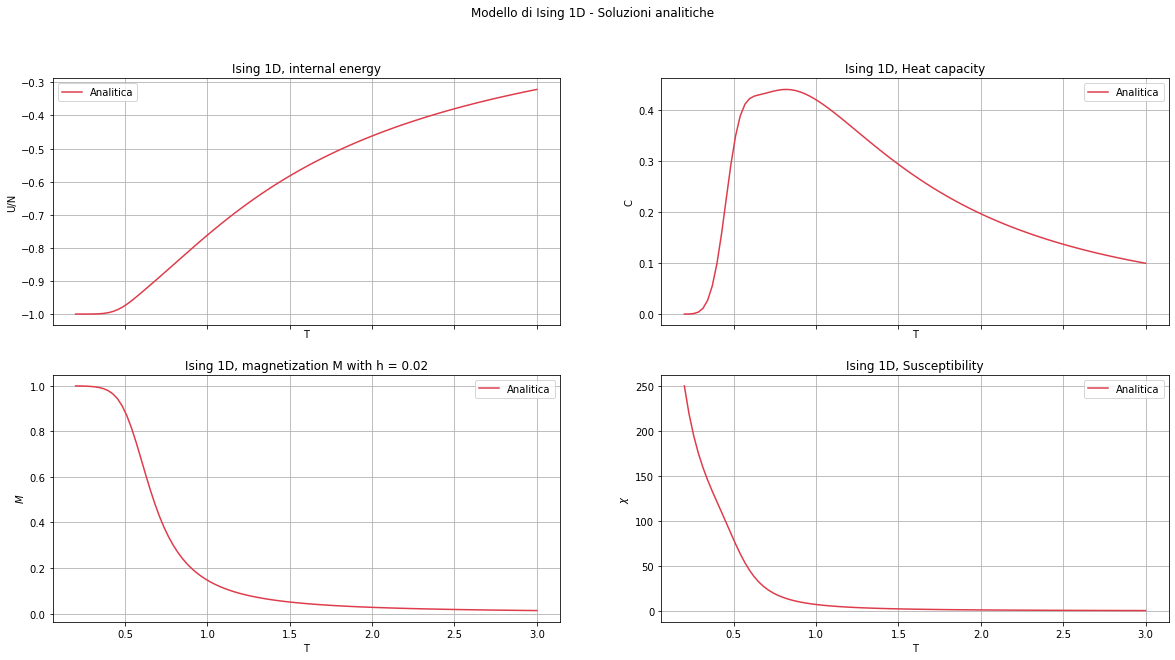

In [4]:
fig, ((en, heat_cap), (magn, chi)) = plt.subplots(2,2,sharex=True, figsize=[20, 10])
fig.suptitle('Modello di Ising 1D - Soluzioni analitiche')

en.plot(T, e, label = "Analitica", color = colors ["analitica"])
en.set_title('Ising 1D, internal energy')
en.set_xlabel('T')
en.set_ylabel('U/N')
en.grid()
en.legend()

heat_cap.plot(T, heat, label = "Analitica", color = colors ["analitica"])
heat_cap.set_title('Ising 1D, Heat capacity')
heat_cap.set_xlabel('T')
heat_cap.set_ylabel('C')
heat_cap.grid()
heat_cap.legend()

magn.plot(T, M, label = "Analitica", color = colors ["analitica"])
magn.set_title('Ising 1D, magnetization M with h = 0.02')
magn.set_xlabel('T')
magn.set_ylabel('$M$')
magn.grid()
magn.legend()

chi.plot(T, X, label = "Analitica", color = colors ["analitica"])
chi.set_title('Ising 1D, Susceptibility')
chi.set_xlabel('T')
chi.set_ylabel('$\chi$')
chi.grid()
chi.legend()

Il modello di Ising può essere anche approcciato utilizzando dei metodi numerici.

## Algoritmo di Mertropolis 
Per prima cosa abbiamo bisogno di un reticolo di spin su cui lavorare. 
- Si parte con il definire un set di N variabili che possono avere valori $\pm 1$.
- Si definiscono le condizioni al controrno in modo tale che ogni spin abbia un uguale numero di primi vicini.
- Si definisce a che temperatura far simulare il sistema e si sceglie a un valore iniziale $\mu$ per ciascuno spin 

Ora si inizia la simulazione: 
- Si genera un nuovo stato $\nu$ scegliendo una probabilità di transizione di prova $T(\nu|\mu)$: si sceglie randomicamente un singolo spin da flippare. 
- Calcoliamo poi la differenza di energia tra il nuovo stato e il vecchio
    - Se $E_{\nu} - E_{\mu} < 0$ allora si definisce la probabilità di transizione $A(\nu|\mu) = 1$, la mossa è cioè sempre accettata
    - Se $E_{\nu} - E_{\mu} > 0 $ si estrae un numero random r tra 0 e 1 e se  $r < A(\nu|\mu) = min[1,e^{-\beta (E_{\nu} - E_{\mu})} ]$ allora flippiamo lo spin, altrimenti si lascia invariato. 

Si continua ciclando l'algoritmo. Questo procedimento permette di arrivare alla configurazione ad energia minore, che è appunto la configurazione a cui il sistema tende. 
## Metodo di Gibbs  

Il metodo di Gibbs è concettualmente il più semplice esempio di Algoritmo di Metropolis, consiste infatti in un Algoritmo di Metropolis in cui la mossa proposta viene sempre accettata. Il processo può essere visto come una realizzazion di una catena di Markov che è costruita sulla base di un set di probabilità di transizione di base. 

Nel caso del modello di Ising l'algoritmo funziona come segue : 
- si sceglie una configurazione iniziale di spin
- Si visitano diversi spin ripetitivamente
- quando lo spin iesimo è visitato 
- si estrae un nuovo valore da una probabilità di transizione definita dagli altri spin (heat-bath) data da 
$$
p(s'_k = \pm 1|{s_j:j\neq k}) = \frac{1}{1 + \exp(\mp 2\beta J \sum_j s_j)}
$$
Questa mossa così campionata viene sempre accettata e si continua così per altri spin 

# Esercizio 1
Simulare il modello si Ising 1D con l'algoritmo di Metropolis e l'algoritmo di Gibbs.

to sample the Boltzmann's weight $p(\{ s_i \}) = \exp(-\beta H)/Z$,
adding also the possibility to restart from a previous spin configuration.
Calcolare le quantità termodinamiche:
1. $U(N,T) = \langle H \rangle_{h=0}$
2. $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 
3. $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$
4. $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$
come funzioni di $T$ nel range $\left[0.5;2.0\right]$ per un sistema di $N=50$ spins con $J=1$.

As usual, use data blocking and give an estimate of the statistical uncertainties.

- <span style="color:red">Show pictures of your estimations of $U(N,T)$, $C(N,T)$, $\chi(N,T)$, $M(N,T,h=0.02)$ and their uncertainties</span> obtained with a large number of *MC steps* (e.g. $M\ge 10^5$) compared with the exact curves. In the same picture show your results obtained with both sampling methods, Metropolis and Gibbs.

A Monte Carlo step will consist in trying to flip one time all the spins of the system. Do not forget to equilibrate your simulations and to use blocking average with blocks large enough.

# Svolgimento Esercizio
## Preliminare: equilibrazione

Prima di procedere con il calcolo delle quantità termodinamiche del sistema determiniamo un numero adeguato di steps per equilibrare il sistema. Un metodo ragionevole per stimare il numero di ste necessari è plottare delle quantità di interesse, l'energia del sistema nel nostro caso e valutare dopo quanti step il valore raggiunge un valore stabile. 
Per eseguire la stima plottiamo quindi le quantità di interesse su 400 blocchi da 100 step ciascuno e valutiamo come evolvono le quantità. 
Per evitare di raggiungere la stabilità in corrispondenza di minimi locali, testiamo il sistema partendo da condizioni iniziali differenti e valutiamo quando raggiungono l'equilibrio

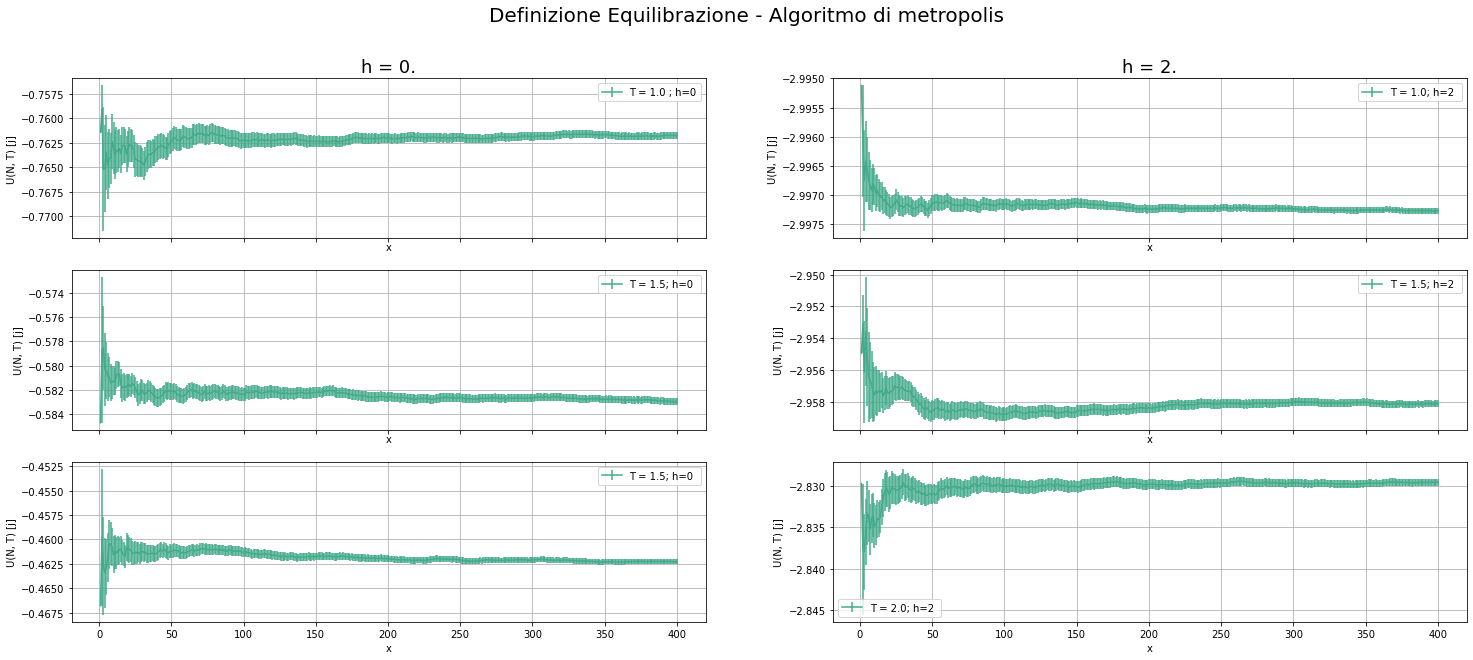

In [5]:
#fig, ((etot, ekin), (epot, temp), (pres)) = plt.subplots(3, 2)
fig, U = plt.subplots(3, 2,sharex=True, figsize=[25, 10])

fig.suptitle('Definizione Equilibrazione - Algoritmo di metropolis', fontsize = 20)

x,stima,prog_av, error = np.loadtxt("ISING_1D/output.metro.eq.ene.h=0.000000t=1.000000", usecols=(0,1,2,3), unpack='true')
U[0][0].errorbar(x,prog_av,yerr=error, label = "T = 1.0 ; h=0", color = colors ["metropolis"])
x,stima,prog_av, error = np.loadtxt("ISING_1D/output.metro.eq.ene.h=0.000000t=1.500000", usecols=(0,1,2,3), unpack='true')
U[1][0].errorbar(x,prog_av,yerr=error, label = "T = 1.5; h=0 ", color = colors ["metropolis"])
x,stima,prog_av, error = np.loadtxt("ISING_1D/output.metro.eq.ene.h=0.000000t=2.000000", usecols=(0,1,2,3), unpack='true')
U[2][0].errorbar(x,prog_av,yerr=error, label = "T = 1.5; h=0 ", color = colors ["metropolis"])

x,stima,prog_av, error = np.loadtxt("ISING_1D/output.metro.eq.ene.h=2.000000t=1.000000", usecols=(0,1,2,3), unpack='true')
U[0][1].errorbar(x,prog_av,yerr=error, label = "T = 1.0; h=2 ", color = colors ["metropolis"])
x,stima,prog_av, error = np.loadtxt("ISING_1D/output.metro.eq.ene.h=2.000000t=1.500000", usecols=(0,1,2,3), unpack='true')
U[1][1].errorbar(x,prog_av,yerr=error, label = "T = 1.5; h=2 ", color = colors ["metropolis"])
x,stima,prog_av, error = np.loadtxt("ISING_1D/output.metro.eq.ene.h=2.000000t=2.000000", usecols=(0,1,2,3), unpack='true')
U[2][1].errorbar(x,prog_av,yerr=error, label = "T = 2.0; h=2 ", color = colors ["metropolis"])

U[0][0].set_title("h = 0.", fontsize = 18)
U[0][1].set_title("h = 2.", fontsize = 18)

for i in range(3):
    for j in range(2): 
        U[i][j].set_xlabel('x')
        U[i][j].set_ylabel('U(N, T) [j]')
        U[i][j].legend()
        U[i][j].grid()

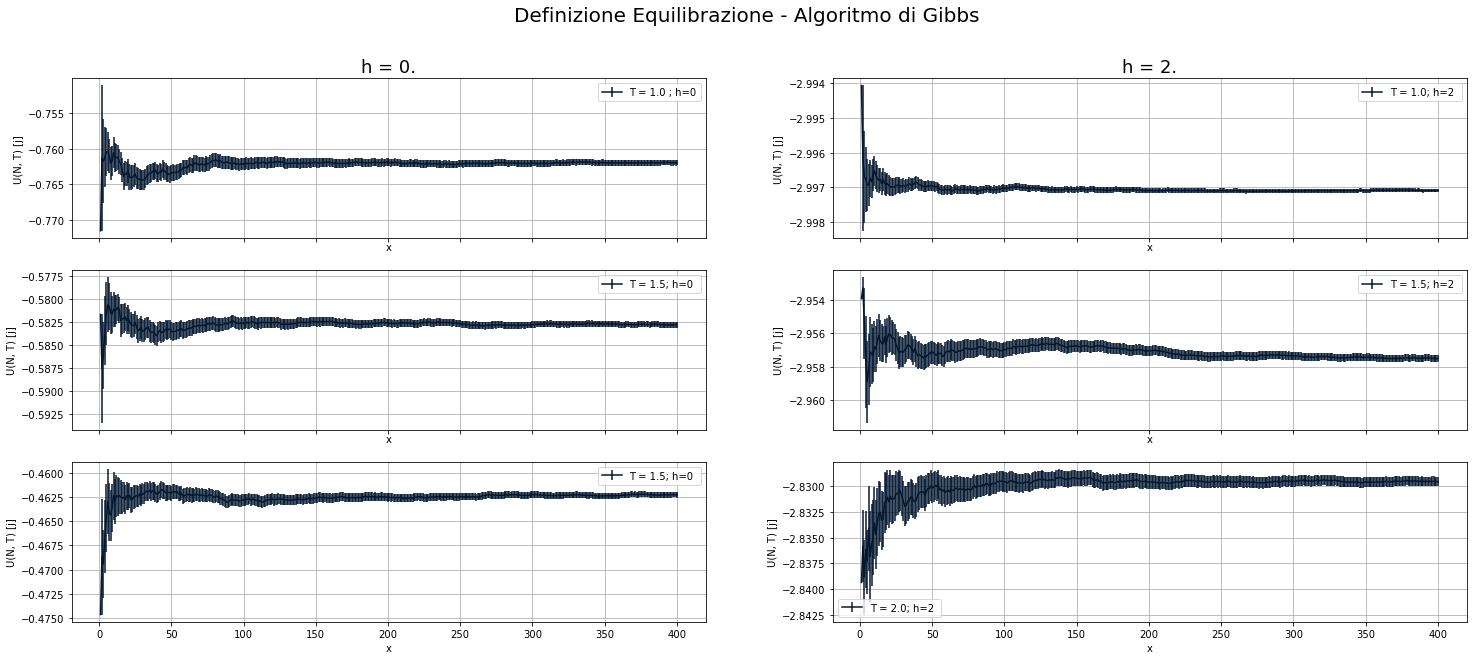

In [6]:
#fig, ((etot, ekin), (epot, temp), (pres)) = plt.subplots(3, 2)
fig, U = plt.subplots(3, 2,sharex=True, figsize=[25, 10])

fig.suptitle('Definizione Equilibrazione - Algoritmo di Gibbs', fontsize = 20)

x,stima,prog_av, error = np.loadtxt("ISING_1D/output.gibbs.eq.ene.h=0.000000t=1.000000.dat", usecols=(0,1,2,3), unpack='true')
U[0][0].errorbar(x,prog_av,yerr=error, label = "T = 1.0 ; h=0", color = colors ["gibbs"])
x,stima,prog_av, error = np.loadtxt("ISING_1D/output.gibbs.eq.ene.h=0.000000t=1.500000.dat", usecols=(0,1,2,3), unpack='true')
U[1][0].errorbar(x,prog_av,yerr=error, label = "T = 1.5; h=0 ", color = colors ["gibbs"])
x,stima,prog_av, error = np.loadtxt("ISING_1D/output.gibbs.eq.ene.h=0.000000t=2.000000.dat", usecols=(0,1,2,3), unpack='true')
U[2][0].errorbar(x,prog_av,yerr=error, label = "T = 1.5; h=0 ", color = colors ["gibbs"])

x,stima,prog_av, error = np.loadtxt("ISING_1D/output.gibbs.eq.ene.h=2.000000t=1.000000.dat", usecols=(0,1,2,3), unpack='true')
U[0][1].errorbar(x,prog_av,yerr=error, label = "T = 1.0; h=2 ", color = colors ["gibbs"])
x,stima,prog_av, error = np.loadtxt("ISING_1D/output.gibbs.eq.ene.h=2.000000t=1.500000.dat", usecols=(0,1,2,3), unpack='true')
U[1][1].errorbar(x,prog_av,yerr=error, label = "T = 1.5; h=2 ", color = colors ["gibbs"])
x,stima,prog_av, error = np.loadtxt("ISING_1D/output.gibbs.eq.ene.h=2.000000t=2.000000.dat", usecols=(0,1,2,3), unpack='true')
U[2][1].errorbar(x,prog_av,yerr=error, label = "T = 2.0; h=2 ", color = colors ["gibbs"])

U[0][0].set_title("h = 0.", fontsize = 18)
U[0][1].set_title("h = 2.", fontsize = 18)

for i in range(3):
    for j in range(2): 
        U[i][j].set_xlabel('x')
        U[i][j].set_ylabel('U(N, T) [j]')
        U[i][j].legend()
        U[i][j].grid()

Osservando i risultati grafici si evince come il grafico si stabilizzi, quindi l'energia interna si stabilizzi dopo un numero di blocchi intorno a 200. Vediamo infatti che le variazioni che il sistema subisce sono minime e rientrano entro le barre di errore definite. 
Utilizziamo qunidi questo risultato per valutare l'andamento delle quantità desiderate in funzione della temperatura. 
Per farlo aggiorniamo il nostro file di input e definiamo un range di temperatura a cui siamo interessati e svolgiamo le simulazioni precedentemente viste e alla fine valutiamo le quantità desiderate dal sistema. 


Studio dell'equilibrazione per diverse temperature, valutare quindi quale stima la migliore. 

Valutare se l'equilibrazione cambia a seconda della quantità che si va a considerare. 

Scegliamo quindi come valore per l'equilibrazione un numero di steps $n = 100000$ 

Riportiamo quindi di seguito i risultati dell'andamento delle quantità termodinamiche in funzione della temperatura del sistema. 
Per ciascuna temperatura si fa evolvere il sistema, utilizzando la media a blocchi, quindi si calcola la stima finale del sistema. 

## Risultati - Algoritmo di Metropolis 

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [17]:
t, ene_t, err_ene_t= np.loadtxt("output.ene.0.020000metro.dat", usecols=(0,1, 2), unpack='true')
t, chi_t, err_chi_t = np.loadtxt("output.chi.0.020000metro.dat", usecols=(0,1, 2), unpack='true')
t, mag_t, err_mag_t= np.loadtxt("output.mag.0.020000metro.dat", usecols=(0,1, 2), unpack='true')
t, heat_t, err_heat_t= np.loadtxt("output.heat.0.020000metro.dat", usecols=(0,1, 2), unpack='true')


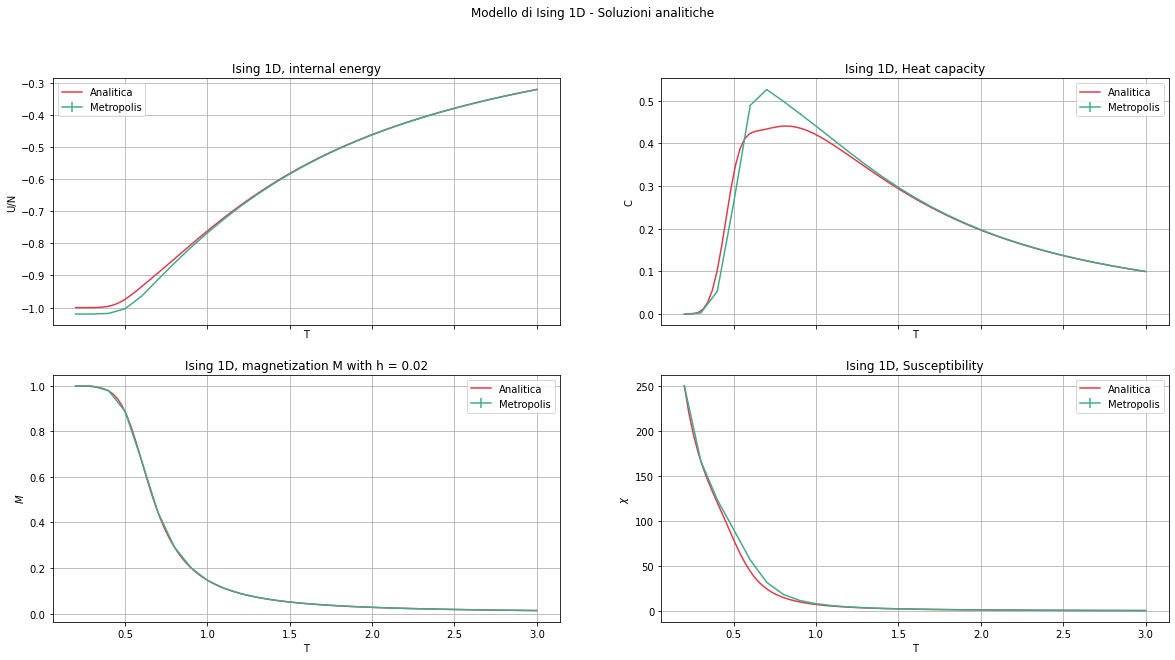

In [18]:
fig, ((en, heat_cap), (magn, chi)) = plt.subplots(2,2,sharex=True, figsize=[20, 10])
fig.suptitle('Modello di Ising 1D - Soluzioni analitiche')

en.plot(T, e, label = "Analitica", color = colors ["analitica"])
en.errorbar(t, ene_t, yerr= err_ene_t , label = "Metropolis", color = colors ["metropolis"])
en.set_title('Ising 1D, internal energy')
en.set_xlabel('T')
en.set_ylabel('U/N')
en.grid()
en.legend()

heat_cap.plot(T, heat, label = "Analitica", color = colors ["analitica"])
heat_cap.errorbar(t, heat_t, yerr= err_heat_t , label = "Metropolis", color = colors ["metropolis"])
heat_cap.set_title('Ising 1D, Heat capacity')
heat_cap.set_xlabel('T')
heat_cap.set_ylabel('C')
heat_cap.grid()
heat_cap.legend()

magn.plot(T, M, label = "Analitica", color = colors ["analitica"])
magn.errorbar(t, mag_t, yerr= err_mag_t , label = "Metropolis", color = colors ["metropolis"])
magn.set_title('Ising 1D, magnetization M with h = 0.02')
magn.set_xlabel('T')
magn.set_ylabel('$M$')
magn.grid()
magn.legend()

chi.plot(T, X, label = "Analitica", color = colors ["analitica"])
chi.errorbar(t, chi_t, yerr= err_chi_t , label = "Metropolis", color = colors ["metropolis"])
chi.set_title('Ising 1D, Susceptibility')
chi.set_xlabel('T')
chi.set_ylabel('$\chi$')
chi.grid()
chi.legend()


## Risultati - Metodo di Gibbs

In [14]:
t, ene_t, err_ene_t= np.loadtxt("output.ene.0.020000gibbs.dat", usecols=(0,1, 2), unpack='true')
t, chi_t, err_chi_t = np.loadtxt("output.chi.0.020000gibbs.dat", usecols=(0,1, 2), unpack='true')
t, mag_t, err_mag_t= np.loadtxt("output.mag.0.020000gibbs.dat", usecols=(0,1, 2), unpack='true')
t, heat_t, err_heat_t= np.loadtxt("output.heat.0.020000gibbs.dat", usecols=(0,1, 2), unpack='true')

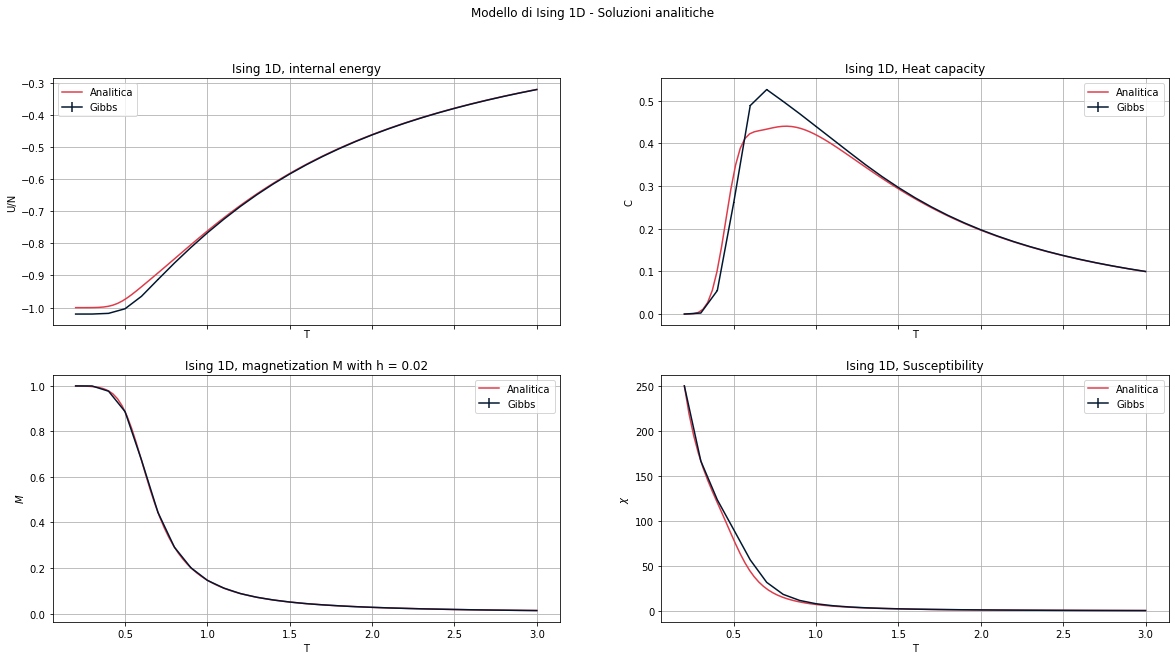

In [15]:
fig, ((en, heat_cap), (magn, chi)) = plt.subplots(2,2,sharex=True, figsize=[20, 10])
fig.suptitle('Modello di Ising 1D - Soluzioni analitiche')

en.plot(T, e, label = "Analitica", color = colors ["analitica"])
en.errorbar(t, ene_t,yerr= err_ene_t , label = "Gibbs", color = colors ["gibbs"])
en.set_title('Ising 1D, internal energy')
en.set_xlabel('T')
en.set_ylabel('U/N')
en.grid()
en.legend()

heat_cap.plot(T, heat, label = "Analitica", color = colors ["analitica"])
heat_cap.errorbar(t, heat_t,yerr= err_heat_t , label = "Gibbs", color = colors ["gibbs"])
heat_cap.set_title('Ising 1D, Heat capacity')
heat_cap.set_xlabel('T')
heat_cap.set_ylabel('C')
heat_cap.grid()
heat_cap.legend()

magn.plot(T, M, label = "Analitica", color = colors ["analitica"])
magn.errorbar(t, mag_t,yerr= err_mag_t , label = "Gibbs", color = colors ["gibbs"])
magn.set_title('Ising 1D, magnetization M with h = 0.02')
magn.set_xlabel('T')
magn.set_ylabel('$M$')
magn.grid()
magn.legend()

chi.plot(T, X, label = "Analitica", color = colors ["analitica"])
chi.errorbar(t, chi_t,yerr= err_chi_t , label = "Gibbs", color = colors ["gibbs"])
chi.set_title('Ising 1D, Susceptibility')
chi.set_xlabel('T')
chi.set_ylabel('$\chi$')
chi.grid()
chi.legend()


### Commento ai risultati 

I risultati ottenuti ci mostrano come il metodo numerico sia corretto, e ci permetta di arrivare ad una stima corretta dell'andamento delle quantità termodinamiche. 

Questa osservazione rappresenta una verifica della correttezza della fisica statistica, come metodo per approcciare la soluzione al modello di Ising. 
Osserviamo infatti che solamente per il modello di Ising in 1D è possibile trovare una soluzione analitica, per dimensioni maggiore è necessario far uso di metodi statistici e simulazioni numeriche. 

Confrontiamo inoltre tra loro i risultati ottenuti dai due metodi, Metropolis e Gibbs 

## Confronto risultati algoritmo di Gibbs e algoritmo di Metropolis 

In [19]:
t_gibbs, ene_t_gibbs, err_ene_t_gibbs= np.loadtxt("output.ene.0.020000gibbs.dat", usecols=(0,1, 2), unpack='true')
t_gibbs, chi_t_gibbs, err_chi_t_gibbs = np.loadtxt("output.chi.0.020000gibbs.dat", usecols=(0,1, 2), unpack='true')
t_gibbs, mag_t_gibbs, err_mag_t_gibbs= np.loadtxt("output.mag.0.020000gibbs.dat", usecols=(0,1, 2), unpack='true')
t_gibbs, heat_t_gibbs, err_heat_t_gibbs= np.loadtxt("output.heat.0.020000gibbs.dat", usecols=(0,1, 2), unpack='true')

t_metro, ene_t_metro ,  err_ene_t_metro= np.loadtxt("output.ene.0.020000metro.dat", usecols=(0,1, 2), unpack='true')
t_metro, chi_t_metro ,  err_chi_t_metro = np.loadtxt("output.chi.0.020000metro.dat", usecols=(0,1, 2), unpack='true')
t_metro, mag_t_metro ,  err_mag_t_metro= np.loadtxt("output.mag.0.020000metro.dat", usecols=(0,1, 2), unpack='true')
t_metro, heat_t_metro ,  err_heat_t_metro= np.loadtxt("output.heat.0.020000metro.dat", usecols=(0,1, 2), unpack='true')


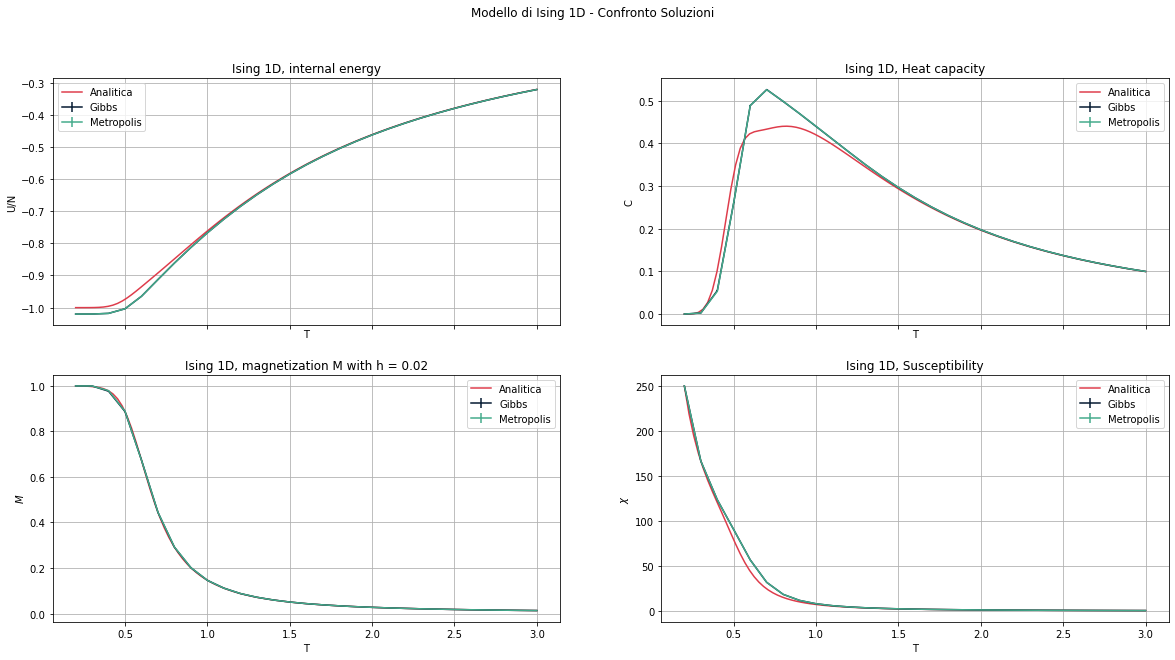

In [20]:
fig, ((en, heat_cap), (magn, chi)) = plt.subplots(2,2,sharex=True, figsize=[20, 10])
fig.suptitle('Modello di Ising 1D - Confronto Soluzioni')

en.plot(T, e, label = "Analitica", color = colors ["analitica"])
en.errorbar( t_gibbs, ene_t_gibbs, yerr = err_ene_t_gibbs ,label = "Gibbs", color = colors ["gibbs"])
en.errorbar(t_metro, ene_t_metro, yerr = err_ene_t_metro , label = "Metropolis", color = colors ["metropolis"])
en.set_title('Ising 1D, internal energy')
en.set_xlabel('T')
en.set_ylabel('U/N')
en.grid()
en.legend()

heat_cap.plot(T, heat, label = "Analitica", color = colors ["analitica"])
heat_cap.errorbar(t_gibbs, heat_t_gibbs,yerr = err_heat_t_gibbs, label = "Gibbs", color = colors ["gibbs"])
heat_cap.errorbar(t_metro, heat_t_metro,yerr = err_heat_t_metro ,  label = "Metropolis", color = colors ["metropolis"])
heat_cap.set_title('Ising 1D, Heat capacity')
heat_cap.set_xlabel('T')
heat_cap.set_ylabel('C')
heat_cap.grid()
heat_cap.legend()

magn.plot(T, M, label = "Analitica", color = colors ["analitica"])
magn.errorbar( t_gibbs, mag_t_gibbs,yerr = err_mag_t_gibbs , label = "Gibbs", color = colors ["gibbs"])
magn.errorbar(t_metro, mag_t_metro,yerr = err_mag_t_metro ,  label = "Metropolis", color = colors ["metropolis"])
magn.set_title('Ising 1D, magnetization M with h = 0.02')
magn.set_xlabel('T')
magn.set_ylabel('$M$')
magn.grid()
magn.legend()

chi.plot(T, X, label = "Analitica", color = colors ["analitica"])
chi.errorbar( t_gibbs, chi_t_gibbs,yerr = err_chi_t_gibbs , label = "Gibbs", color = colors ["gibbs"])
chi.errorbar( t_metro, chi_t_metro, yerr = err_chi_t_metro ,label = "Metropolis", color = colors ["metropolis"])
chi.set_title('Ising 1D, Susceptibility')
chi.set_xlabel('T')
chi.set_ylabel('$\chi$')
chi.grid()
chi.legend()

Anche confrontanto le due soluzioni numeriche si nota come non si osservino significative differenze tra i due metodi numerici 

Questi risultati mostrano la correttezza dell'approccio statistico nell'affrontare il problema di Ising